# Imports

In [1]:
%matplotlib inline
import matplotlib.pylab as pylab
pylab.rcParams['figure.figsize'] = (10, 6)
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import math
from sklearn.feature_selection import VarianceThreshold
from sklearn.cross_validation import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, roc_auc_score, classification_report
from dateutil.parser import parse
from datetime import timedelta
import pprint as pp

In [3]:
# Read in the pandas.DataFrame from csv
data = pd.read_csv('../Data/ebay_data_rf_endtime.csv', index_col=False)

# Random forest model

Our eBay data contains primarily categorical variables. Thus, random forest is a natural option for modeling the dataset, because the random forest algorithm is based on decision trees which naturally handle categorical data.

## Preprocessing

In [4]:
# Separate target variable from inputs
y = data.sellingState
T = data.endTime
X = data.drop(['sellingState','endTime'], axis=1)
T_dt = [parse(x) for x in T]

We can easily see the 90 day limitation of the ebay API:

In [5]:
DeltaT = (T_dt[0]-T_dt[-1])
print("Total days of data:", DeltaT.total_seconds()/86400)

Total days of data: 89.98267361111111


In [6]:
# Calculate the sample weights
def get_days_diff(dt1 , dt2): 
    return (dt1 - dt2).total_seconds()/(86400) 
    # 86400 s/day = 60 s/min * 60 min/hr *24 hr/day

def get_weight(dt, dt_ref, sigma):

    hrs = get_days_diff(dt,dt_ref)
    
    return math.exp( -hrs**2 / (2 * sigma) )

def get_sample_weights(dt_ls, sigma):
    latest = max(dt_ls)
    return [get_weight(x, latest, sigma) for x in dt_ls]

sw = get_sample_weights(T_dt, 2)

In [7]:
# Split the data into train and test. 
#Since we are going to optimize sigma, we split into old and new
frac = 0.1
ind = math.ceil(42028 * frac)

test_ind = range(0,ind)
train_ind = range(ind,len(y))

X_train = X.iloc[train_ind]
X_test = X.iloc[test_ind]
y_train = y[list(train_ind)]
y_test = y[list(test_ind)]

T_dt_train = T_dt[ind:len(y)]

In [8]:
min_sigma = (T_dt[0]-T_dt[ind]).total_seconds()/86400
max_sigma = 2*(T_dt_train[0]-T_dt_train[-1]).total_seconds()/86400
print(min_sigma, max_sigma)

5.420335648148148 169.1246759259259


In [9]:
print(X_train.shape)
print(X_test.shape)
print(len(y_train))
print(len(y_test))
print(len(T_dt_train))

(40637, 20)
(4203, 20)
40637
4203
40637


## Classification

In [11]:
# Assign the classifier
n_estimators = 200
max_features = None
weights = {0: 1, 1: 1}
RANDOM_STATE = 3
clf = RandomForestClassifier(n_estimators = n_estimators,
                             max_features=max_features,
                             class_weight=weights,
                             oob_score=False,
                             n_jobs = 3,
                             random_state = RANDOM_STATE
                            )

In [12]:
# Calculate the Auc_error for a range of time windows
aucs = []

# Range of sigma to explore (in days)
n_pts = 12
pts = np.linspace(min_sigma, max_sigma, n_pts)

for sig in pts:
    sw = get_sample_weights(T_dt_train, sig)
    clf.fit(X_train, y_train, sw)
    y_pred = clf.predict_proba(X_test)[:,1]
    aucs.append( (sig, roc_auc_score(y_test, y_pred)) )
    
aucs

[(5.4203356481481482, 0.80942259675405748),
 (20.302548400673398, 0.82021061635918069),
 (35.18476115319865, 0.81895015489896883),
 (50.066973905723898, 0.81967818005271187),
 (64.949186658249147, 0.82205079299024353),
 (79.831399410774409, 0.8226099320294078),
 (94.713612163299658, 0.82167602996254674),
 (109.59582491582491, 0.81951923521524039),
 (124.47803766835015, 0.82002670273269507),
 (139.36025042087542, 0.81850002311924908),
 (154.24246317340067, 0.81945010866047074),
 (169.12467592592591, 0.82016171914736213)]

## Plot the results

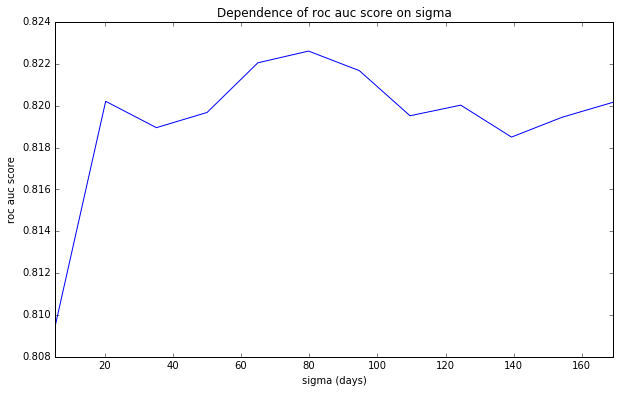

In [13]:
xs, ys = zip(*aucs)

plt.plot(xs, ys)

plt.title("Dependence of roc auc score on sigma")
plt.xlim(min_sigma, max_sigma)
plt.xlabel("sigma (days)")
plt.ylabel("roc auc score")

plt.show()

In [14]:
# Find the maximum value
max(aucs, key = lambda x: x[1])

(79.831399410774409, 0.8226099320294078)

It doesn't appear that over the timescale of the available data that the there is any benefit to adjusting the sample weights for older data. While older data doesn't appear to be neccessary to constrain the fit, it doesn't harm the fitting either. Perhaps as the data set grows, the time dependence will become an issue. At present, we will sample all data points equally.